In [81]:

import os
import numpy as np
import time
import csv
import random
import os
import matplotlib.pyplot as plt
import math
import pandas as pd

In [82]:
train = pd.read_csv('../v4/train_data.csv')
test = pd.read_csv('../v4/test_data.csv')
# 197026行までtrain

In [83]:
data = pd.concat([train, test], ignore_index=True)
data['index'] = list(range(len(data)))
data.head(10)

,Unnamed: 0,student_id,skill_id,skill_mastery,ability_profile,problem_difficulty,problem_alpha,correctness,dkt,index
0,0,2,83,0.563882,0,1.281928,0.825713,1,0.502212,0
1,1,2,82,0.742560,0,0.288214,2.000000,1,0.674110,1
2,2,2,82,0.844854,0,1.941272,0.250000,1,0.819094,2
3,3,2,37,0.606742,0,-1.866635,2.000000,0,0.642270,3
4,4,2,37,0.608723,0,2.000000,0.836878,1,0.648409,4
5,5,2,37,0.608434,0,1.446091,2.000000,1,0.751851,5
6,6,2,80,0.694021,0,0.115305,1.104574,1,0.707201,6
7,7,2,38,0.695431,0,1.004856,0.643189,1,0.736440,7
8,8,2,80,0.837221,0,1.185574,1.866057,1,0.708657,8
9,9,2,81,0.103216,0,0.245556,1.098142,0,0.594880,9


In [84]:
import tqdm
students = data['student_id'].unique()
skills = data['skill_id'].unique()
timedata = pd.DataFrame()

for skill in tqdm.tqdm(skills):
  for s in students:
    y = (data[(data['student_id']==s) & (data['skill_id'] == skill)]['dkt'].tolist())[:5]
    if len(y) <= 4:
      continue
    L = [s] + [skill] + y
    y = pd.DataFrame([L])
    timedata = pd.concat([timedata, y], ignore_index=True)
  
timedata.head()

100%|██████████| 104/104 [01:46<00:00,  1.02s/it]


,0,1,2,3,4,5,6
0,2,83,0.502212,0.622330,0.728867,0.606922,0.719697
1,3,83,0.612175,0.757658,0.640368,0.620287,0.784562
2,7,83,0.360433,0.326584,0.290203,0.262928,0.445392
3,8,83,0.619212,0.540097,0.718237,0.825055,0.669562
4,9,83,0.612175,0.683997,0.512877,0.667168,0.750383


In [85]:
timedata.columns = ['student_id', 'skill_id', '1', '2', '3', '4', '5']

In [86]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# クラスタリングするデータ
data = timedata.drop(['student_id', 'skill_id'], axis=1)
print(np.max(data),np.min(data))

# 前処理として標準化を行う
nm_data = TimeSeriesScalerMeanVariance().fit_transform(data)
print(np.max(nm_data),np.min(nm_data))

/Users/riku/opt/anaconda3/envs/tenso/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/Users/riku/opt/anaconda3/envs/tenso/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


1    0.967048
2    0.974662
3    0.975973
4    0.974016
5    0.974638
dtype: float64 1    0.099769
2    0.101877
3    0.094855
4    0.095155
5    0.088846
dtype: float64
1.9993396980759317 -1.999326196850505


In [87]:
# クラスタ数
n = 5

# 元データのプロットレンジ
ymax = 1
ymin = 0

# 標準化データのプロットレンジ
nm_ymax = 2.5
nm_ymin = -2.5

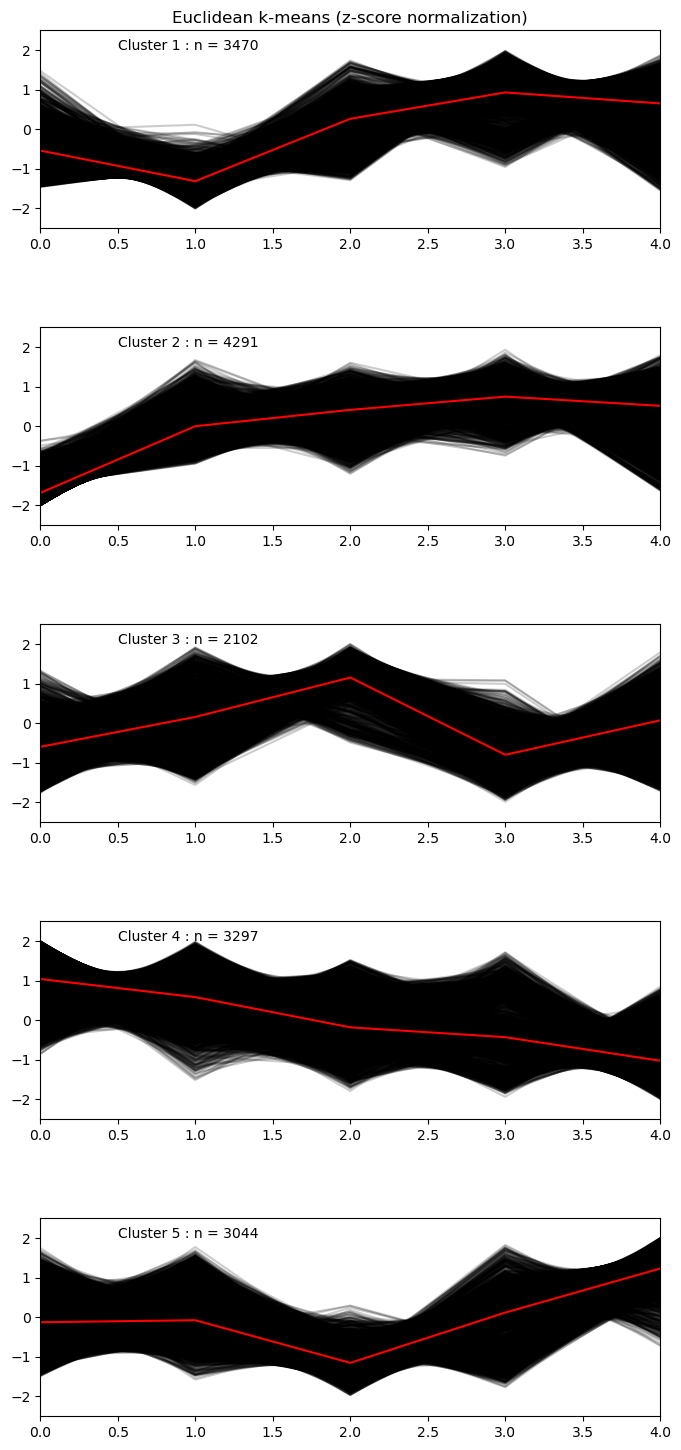

In [88]:
from tslearn.clustering import TimeSeriesKMeans

km_euclidean = TimeSeriesKMeans(n_clusters=n, random_state=42, metric="euclidean")
labels_euclidean = km_euclidean.fit_predict(nm_data)

# 標準化したデータのプロット
fig, axes = plt.subplots(n, figsize=(8.0, 18.0))
plt.subplots_adjust(hspace=0.5)
for i in range(n):
    ax = axes[i]
    # データのプロット
    for xx in nm_data[labels_euclidean == i]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
    # 重心のプロット
    ax.plot(km_euclidean.cluster_centers_[i].ravel(), "r-")
    # 軸の設定とテキストの表示
    ax.set_xlim(0, 4)
    ax.set_ylim(nm_ymin, nm_ymax)
    datanum = np.count_nonzero(labels_euclidean == i)
    ax.text(0.5, (nm_ymax*0.9+nm_ymin*0.1), f'Cluster {(i + 1)} : n = {datanum}')
    if i == 0:
        ax.set_title("Euclidean k-means (z-score normalization)")

In [91]:
timedata['cluster'] = labels_euclidean
timedata[timedata['student_id'] == 2]

,student_id,skill_id,1,2,3,4,5,cluster
0,2,83,0.502212,0.622330,0.728867,0.606922,0.719697,1
647,2,82,0.674110,0.819094,0.778835,0.811561,0.777366,1
1169,2,37,0.642270,0.648409,0.751851,0.792750,0.853653,0
1792,2,38,0.736440,0.722753,0.649864,0.652901,0.792533,4
2010,2,81,0.594880,0.459457,0.643978,0.443164,0.499566,2
3833,2,31,0.734728,0.818929,0.826414,0.815669,0.807690,1
5670,2,7,0.819540,0.835037,0.837038,0.839650,0.718371,3
6082,2,55,0.737695,0.663507,0.716579,0.791083,0.836805,0
6349,2,34,0.813484,0.878189,0.900239,0.914834,0.924000,1
6891,2,40,0.835928,0.842001,0.849664,0.828442,0.828360,2


In [92]:
train_data = pd.read_csv('../v4/train_data.csv')
test_data = pd.read_csv('../v4/test_data.csv')

train_data_v5 = pd.merge(train_data, timedata, on=['student_id', 'skill_id'], how='left')
test_data_v5 = pd.merge(test_data, timedata, on=['student_id', 'skill_id'], how='left')

train_data_v5 = train_data_v5.drop(['Unnamed: 0', '1', '2', '3', '4', '5'], axis=1)
test_data_v5 = test_data_v5.drop(['Unnamed: 0','1', '2', '3', '4', '5'], axis=1)
train_data_v5.head()

,student_id,skill_id,skill_mastery,ability_profile,problem_difficulty,problem_alpha,correctness,dkt,cluster
0,2,83,0.563882,0,1.281928,0.825713,1,0.502212,1.0
1,2,82,0.742560,0,0.288214,2.000000,1,0.674110,1.0
2,2,82,0.844854,0,1.941272,0.250000,1,0.819094,1.0
3,2,37,0.606742,0,-1.866635,2.000000,0,0.642270,0.0
4,2,37,0.608723,0,2.000000,0.836878,1,0.648409,0.0


In [93]:
train_data_v5.to_csv('../v5/train_data.csv')
test_data_v5.to_csv('../v5/test_data.csv')